<a href="https://colab.research.google.com/github/pthkbs123/SkillTreePython-DataAnalysis/blob/main/05.%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EA%B8%B0%EB%B0%98%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D/ch05_13_%EC%82%AC%EC%9D%B4%ED%82%B7%EB%9F%B0%EC%8B%A4%EC%8A%B5_%EC%95%99%EC%83%81%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch05.13. 사이킷런 실습 - 앙상블

---
* 날짜: 2022-05-30
* 이름: 박태현

## 학습내용
    - 모델 앙상블에 대한 개념을 이해한다.
    - 배깅(bagging) : 부트스트랩(bootstrp) 샘플링을 통한 분류 앙상블 기법을 이해한다.
    - 부스팅 기반의 에이다부스트(AdaBoost) 알고리즘을 이해한다.

## 학습자료
- [머신러닝 교과서 with파이썬, 사이킷런, 텐서플로](http://www.kyobobook.co.kr/product/detailViewKor.laf?mallGb=KOR&ejkGb=KOR&barcode=9791165215187)
- 7장. 다양한 모델을 결합한 앙상블 학습

```
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib.colors import ListedColormap

def draw_decision_region(model, X, y, 
                         X_test=[], y_test=[], 
                         features=[], labels=[], title=''): # 결정경계

  colors = ('orangered', 'dodgerblue', 'limegreen', 'fuchsia', 'blueviolet')
  cmap = ListedColormap(colors[:len(np.unique( y))])

  x0mn, x0mx = X[:,0].min() -1, X[:,0].max() +1
  x1mn, x1mx = X[:,1].min() -1, X[:,1].max() +1
  x0 = np.arange(x0mn, x0mx, 0.02)
  x1 = np.arange(x1mn, x1mx, 0.02)
  #print('* arange', x0.shape, x1.shape)
  X0, X1 = np.meshgrid(x0, x1)
  #print('* meshgrid', x0.shape, x1.shape)
  x0, x1 = X0.ravel(), X1.ravel()
  #print('* ravel', x0.shape, x1.shape)
  x_every = np.array([x0, x1]).T
  #print('* concat', x_set.shape)
  y_pred = model.predict(x_every)
  #print('* y_pred', y_pred.shape)
  Y_pred = y_pred.reshape(X0.shape)
  #print('* y_pred', y_pred.shape)

  if not len(labels): labels=[i for i in range(len(np.unique(y)))]
  plt.contourf(X0, X1, Y_pred, alpha=0.4, cmap=cmap )
  for idx, c in enumerate(np.unique(y)):
    plt.scatter(x = X[y == c, 0], 
                y = X[y == c, 1],
                alpha=0.8,
                c=colors[idx],
                label=labels[idx],
                marker='x',
                linewidth=2)
  if len(X_test):
    for idx, c in enumerate(np.unique(y_test)):
      plt.scatter(x = X_test[y_test == c, 0], 
                  y = X_test[y_test == c, 1],
                  alpha=0.8,
                  c=colors[idx],
                  marker='o',
                  edgecolor='k',
                  linewidth=2)
  
  if features:
    plt.xlabel(features[0])
    plt.ylabel(features[1])
  if title:
    plt.title(title)
  plt.legend()

## 데이터 소개 : 와인 데이터셋
---


```
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
```

#### 데이터 가져오기

In [3]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print(df_wine.shape)
df_wine.head()

(178, 14)


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


#### 학습을 위한 데이터 처리
* 와인 클래스 2와 클래스 3만 사용 (1은 제거)
* 두개의 특성 Alcohol과 'OD280/OD315 of diluted wines'만 사용

In [4]:
# 클래스 라벨이 1인 데이터 제거
mask = df_wine['Class label'] != 1
df_wine = df_wine[mask]
# X,y를 구분(X는 두 개 피쳐만 사용)
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values
y = df_wine['Class label'].values
X.shape, y.shape

((119, 2), (119,))

#### 전처리

In [5]:
from sklearn.preprocessing import LabelEncoder
# 라벨 인코딩 (1,2) -> (0,1)
le = LabelEncoder()
y = le.fit_transform(y)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size = 0.2,
                                                 stratify = y,
                                                 random_state = 1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((95, 2), (24, 2), (95,), (24,))

#### 분포 시각화

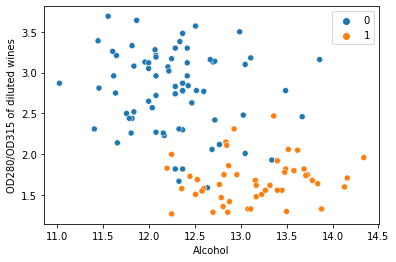

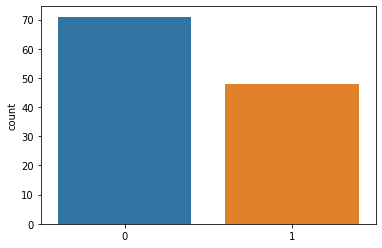

In [6]:
# 속성이 2개이므로 2차원. 속성1, 속성2 산점도(x)
feature1 = X[:,0]
feature2 = X[:,1]
sns.scatterplot(x=feature1, y=feature2, hue = y)
plt.xlabel('Alcohol')
plt.ylabel('OD280/OD315 of diluted wines')
plt.show()
# 클래스별 갯수(counterplot)
sns.countplot(x=y)
plt.show()

## 다수결 투표 방식을 사용한 예측
---

<p align='center'>
<img src=https://git.io/Jtskl?raw=true width=600>
</p>

앙상블의 기본 개념.

#### 모델 구성

In [7]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

lr = LogisticRegression(random_state=1,
                        penalty='l2')
tree = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=1)
knn = KNeighborsClassifier(n_neighbors=1,
                           p = 2,
                           metric='minkowski')

voting = VotingClassifier(estimators =  [('logistic',lr),
                                        ('tree', tree),
                                        ('knn',knn)],
                          voting = 'soft', # (hard,soft)
                          )
models = ['lr', 'tree', 'knn', 'voting']

#### k-겹 교차검증

In [8]:
from sklearn.model_selection import cross_val_score
print('10-겹 교차검증')
for model in models : 
  scores = cross_val_score(
      estimator=eval(model),
      X = X_train,
      y = y_train,
      cv = 10,
      scoring = 'accuracy')
  print(f'{model} ACC : {scores.mean():.2f} (+/- {scores.std():.2f}) ')

10-겹 교차검증
lr ACC : 0.88 (+/- 0.13) 
tree ACC : 0.88 (+/- 0.09) 
knn ACC : 0.91 (+/- 0.11) 
voting ACC : 0.93 (+/- 0.11) 


#### 스코어 계산

In [9]:
for model in models :
  # 학습
  eval(model).fit(X_train,y_train)
  # 평가
  train_score = eval(model).score(X_train, y_train)
  test_score = eval(model).score(X_test, y_test)

  print(f'{model} Train ACC : {train_score:.2f}, Test ACC : {test_score:.2f} ')

lr Train ACC : 0.89, Test ACC : 0.92 
tree Train ACC : 0.92, Test ACC : 0.88 
knn Train ACC : 1.00, Test ACC : 0.92 
voting Train ACC : 0.96, Test ACC : 0.92 


#### 모델 별 분류경계 시각화

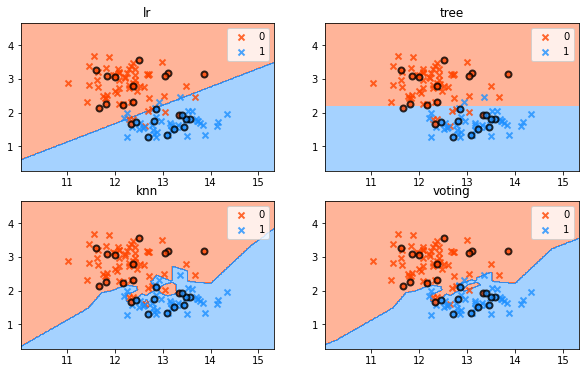

In [10]:
plt.figure(figsize = (10,6))
for i, model in enumerate(models):
  plt.subplot(2,2,i+1)
  draw_decision_region(eval(model),
                       X_train, y_train,
                       X_test, y_test,
                       title = model)
plt.show()

## 배깅(Bagging: Bootrstrap aggregating)
----

<p align='center'>
<img src=https://git.io/Jtsk4?raw=true width=500>
</p>

#### 모델 구성

```
sklearn.ensemble.BaggingClassifier(
                                  base_estimator=None, 
                                  n_estimators=10, *, 
                                  max_samples=1.0, 
                                  max_features=1.0, 
                                  bootstrap=True, 
                                  bootstrap_features=False, 
                                  oob_score=False, 
                                  warm_start=False, 
                                  n_jobs=None, 
                                  random_state=None, 
                                  verbose=0

```

In [11]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth = None,
                              random_state=1)
bagging = BaggingClassifier(base_estimator=tree,
                            n_estimators=500,
                            random_state = 1)
models = ['tree', 'bagging']

#### k-겹 교차검증

In [12]:
print('10-겹 교차검증')
for model in models : 
  scores = cross_val_score(
      estimator=eval(model),
      X = X_train,
      y = y_train,
      cv = 10,
      scoring = 'accuracy')
  print(f'{model} ACC : {scores.mean():.2f} (+/- {scores.std():.2f}) ')

10-겹 교차검증
tree ACC : 0.88 (+/- 0.12) 
bagging ACC : 0.90 (+/- 0.10) 


#### 스코어 계산

In [13]:
for model in models :
  # 학습
  eval(model).fit(X_train,y_train)
  # 평가
  train_score = eval(model).score(X_train, y_train)
  test_score = eval(model).score(X_test, y_test)

  print(f'{model} Train ACC : {train_score:.2f}, Test ACC : {test_score:.2f} ')

tree Train ACC : 1.00, Test ACC : 0.83 
bagging Train ACC : 1.00, Test ACC : 0.92 


#### 모델 별 분류경계 시각화

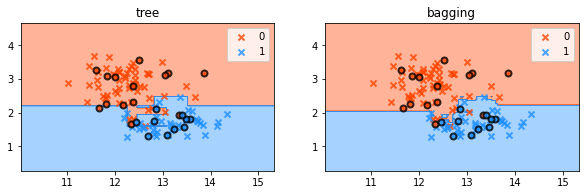

In [14]:
plt.figure(figsize = (10,6))
for i, model in enumerate(models):
  plt.subplot(2,2,i+1)
  draw_decision_region(eval(model),
                       X_train, y_train,
                       X_test, y_test,
                       title = model)
plt.show()

##  에이다부스트(AdaBoost)
---


<p align='center'>
<img src=https://camo.githubusercontent.com/e0966809177c396bd5f64c2142e11ca7f31dfb05094ac671c5f425fbd2cd2f91/68747470733a2f2f6769742e696f2f4a74736b30?raw=true width=500>
</p>

#### 모델구성

```
class sklearn.ensemble.AdaBoostClassifier(
                          base_estimator=None, *, 
                          n_estimators=50, 
                          learning_rate=1.0, 
                          algorithm='SAMME.R', 
                          random_state=None)[source]¶

```

In [15]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth = None,
                              random_state=1)
ada = AdaBoostClassifier(base_estimator=tree,
                            n_estimators=500,
                            learning_rate = 0.1,
                            random_state = 1)
models = ['tree', 'ada']

#### k-겹 교차검증

In [16]:
print('10-겹 교차검증')
for model in models : 
  scores = cross_val_score(
      estimator=eval(model),
      X = X_train,
      y = y_train,
      cv = 10,
      scoring = 'accuracy')
  print(f'{model} ACC : {scores.mean():.2f} (+/- {scores.std():.2f}) ')

10-겹 교차검증
tree ACC : 0.88 (+/- 0.12) 
ada ACC : 0.85 (+/- 0.13) 


#### 스코어 계산

In [17]:
for model in models :
  # 학습
  eval(model).fit(X_train,y_train)
  # 평가
  train_score = eval(model).score(X_train, y_train)
  test_score = eval(model).score(X_test, y_test)

  print(f'{model} Train ACC : {train_score:.2f}, Test ACC : {test_score:.2f} ')

tree Train ACC : 1.00, Test ACC : 0.83 
ada Train ACC : 1.00, Test ACC : 0.83 


#### 모델 별 분류경계 시각화

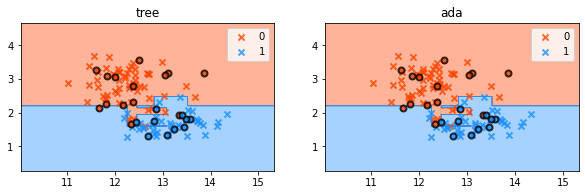

In [18]:
plt.figure(figsize = (10,6))
for i, model in enumerate(models):
  plt.subplot(2,2,i+1)
  draw_decision_region(eval(model),
                       X_train, y_train,
                       X_test, y_test,
                       title = model)
plt.show()

## 앙상블 모델 정리
---

In [19]:
from sklearn.ensemble import *
from sklearn.tree import *
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Voting
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = None,       
                              random_state = 1)
voting = VotingClassifier(estimators = [('logistic', lr),
                                        ('tree',tree),
                                        ('knn', knn)],
                                        voting = 'soft') # {hard, soft}

# Bagging
# tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = None, random_state = 1)
bagging = BaggingClassifier(base_estimator = tree, n_estimators = 500, random_state = 1)                                        



# Adaboost
#tree = DecisionTreeClassifier(criterion = 'entropy', max_depth =1,random_state = 1) # Adaboost는 tree의 max_depth 깊이를 낮게(적당히) 맞추면 됨
ada = AdaBoostClassifier(base_estimator = tree,
                         n_estimators = 500,learning_rate = 0.1,
                         random_state = 1)

# random forest
rnd_tree = RandomForestClassifier(random_state = 1)

# 그래디언트 부스팅
gbrt = GradientBoostingClassifier(random_state=1)

# xgb
xgb = XGBClassifier(random_state = 1)

# light bgm
lgb = LGBMClassifier(random_state = 1)

models = ['tree', 'rnd_tree', 'bagging', 'ada', 'xgb', 'lgb', 'voting', 'gbrt']

#### k-겹 교차검증

In [20]:
from sklearn.model_selection import cross_val_score
print('10-겹 교차검증')

for model in models : 
  scores = cross_val_score(estimator=eval(model),
                           X = X_train, y = y_train, cv = 10, 
                           scoring = 'accuracy')
  print(f'{model} Acc : {scores.mean() : .3f} (+/- {scores.std():.3f})')

10-겹 교차검증
tree Acc :  0.883 (+/- 0.121)
rnd_tree Acc :  0.903 (+/- 0.102)
bagging Acc :  0.902 (+/- 0.105)
ada Acc :  0.851 (+/- 0.129)
xgb Acc :  0.904 (+/- 0.087)
lgb Acc :  0.913 (+/- 0.096)
voting Acc :  0.916 (+/- 0.115)
gbrt Acc :  0.841 (+/- 0.107)


#### 스코어 계산

In [21]:
for model in models : 
  # 학습
  eval(model).fit(X_train, y_train)
  # 평가
  train_score = eval(model).score(X_train, y_train)
  test_score = eval(model).score(X_test, y_test)
  print(f'{model} Acc : {train_score : .3f} {test_score : .3f}')

tree Acc :  1.000  0.833
rnd_tree Acc :  1.000  0.917
bagging Acc :  1.000  0.917
ada Acc :  1.000  0.833
xgb Acc :  0.968  0.917
lgb Acc :  0.968  0.917
voting Acc :  1.000  0.917
gbrt Acc :  1.000  0.917


#### 모델 별 분류경계 시각화

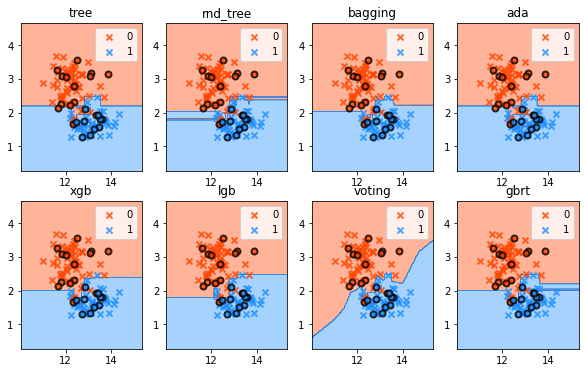

In [26]:
plt.figure(figsize = (10,6))
for i, model in enumerate(models):
  plt.subplot(2,4,i+1)
  draw_decision_region(eval(model),
                       X_train, y_train,
                       X_test, y_test,
                       title = model)
plt.show()

## 알고리즘 정해서 발표하기

1. PCA, KNN
2. 앙상블(Ensemble), 배깅(Bagging)
3. 부스팅(Bossting)

포함되어야 할 내용
- 개념 설명
- (앙상블, 배깅, 부스팅)의 경우 관련 모델
- 사이킷런 구현시 함수의 각 파라미터

In [ ]:
from sklearn.decomposition import PCA
# 각 매개변수에는 기본값이 들어가 있음.
pca = PCA(n_components=None, # (int,float,'mle'). 변환할 차원의 수. 'mle'를 선택하고, svd_solver = 'full'이면 토마스 민카의 차원 선택 방식을 사용.
          copy=True, # False이면 fit에 전달된 데이터를 덮어쓰고 fit(X).transform(X)을 실행해도 예상한 결과가 나오지 않으므로 대신 fit_transform(X)를 사용할 것.
          whiten=False, # True일 때, components_벡터에 n_samples의 제곱근을 곱한 다음 특이값으로 나누어 단위 구성 요소별 분산과 uncorrelated한 값을 출력.
          svd_solver=['full', 'arpack', 'randomized'], # ('auto', 'full', 'arpack', 'randomized').
          # Scikit-Learn에서는 PCA를 계산할 때 특이값 분해(SVD, Singular Value Decomposition)를 이용해 계산. 이 떄 어떤 방식을 사용할 것 인지를 입력.
          # 'full' : LAPACK solver를 호출. 'arpack' :  ARPACK solver를 호출. 
          # 'randomized' : 랜덤 PCA라는 확률적 알고리즘을 사용할 때 호출. 근사치를  'auto' : 원본 데이터의 크기나 차원 수가 500보다 크고, 축소할 차원이 이것들의 80%보다 작으면 sklearn은 자동으로 랜덤 PCA 알고리즘을 사용
          tol=0, # svd_solver == 'arpack'을 사용할 때, 특이값의 허용오차.
          iterated_power='auto', # svd_solver = 'randomized 일 때 거듭제곱식 반복 횟수
          random_state=None, # 난수 값
          )


In [ ]:
KNeighborsClassifier(algorithm='auto', # ('ball_tree', 'kd_tree', 'brute', 'auto') 사용할 알고리즘 선택.
                     leaf_size=30, # 트리에서 뻗어나갈 잎의 크기. 너무 작으면 느리고 노이즈 생성. 너무 크면 성능 저하.
                     metric='minkowski', # 거리 측정 박식을 변경하는 매개변수 선택.
                     metric_params=None, # 메트릭 함수 추가 키워드
                     n_jobs=1, # 이웃을 검색하는데 실행하는 병렬 작업 수
                     n_neighbors = 5, # 검색할 이웃의 수
                     p=2, # minkowski사용 시 매개변수 선택
                     weights='uniform' # ('uniform', 'distance') 예측에 사용 할 가중치. 'uniform' : 각 이웃에게 동일한 가중치, 'distance' : 가까운 이웃에게 더 큰 영향을 받음
                     )